In [2]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrut\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\shrut\AppData\Roaming\nltk_data...


True

In [5]:
df=pd.read_csv("../data/raw/sentiment_baseline.csv")

In [6]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [7]:
df.shape

(53043, 3)

In [8]:
df.columns

Index(['Unnamed: 0', 'statement', 'status'], dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [10]:
df.isnull().sum()

Unnamed: 0      0
statement     362
status          0
dtype: int64

In [11]:
df.dropna(inplace=True)

In [12]:
df['status'].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

**Label Distribution**

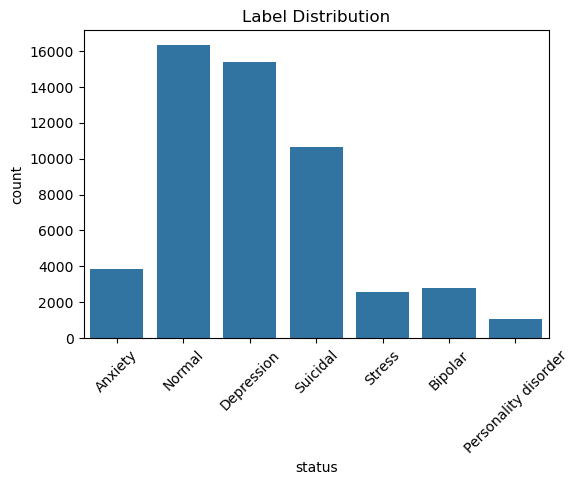

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='status')
plt.xticks(rotation=45)
plt.title('Label Distribution')
plt.show()

Dataset is Imbalanced

**Text Cleaning**

In [19]:
stop_words=set(stopwords.words('english'))
lemmatizer=WordNetLemmatizer()

def clean_text(text):
    #handle NaN
    if pd.isna(text):
        return ''
        
    text=text.lower()

    #remove URLs
    text=re.sub(r'http\S+\www\S+','',text)

    #remove usernames (@user)
    text=re.sub(r'@\w+','',text)

    #remove hashtags
    text=re.sub(r'#\w+', '', text)

    #remove emojis & special characters
    text=re.sub(r'[^a-z\s]', '', text)

    #remove extra spaces
    text=re.sub(r'\s+', ' ', text).strip()

    #lemmatization and remove stopwords
    tokens=text.split()
    tokens=[lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

Applying Cleaning to Dataset

In [20]:
df['clean_text']=df['statement'].apply(clean_text)

In [21]:
df[['statement','clean_text']].head()

,statement,clean_text
0,oh my gosh,oh gosh
1,"trouble sleeping, confused mind, restless hear...",trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,ive shifted focus something else im still worried
4,"I'm restless and restless, it's been a month n...",im restless restless month boy mean


**Label Normalization**

In [29]:
label_map = {
    "Anxiety": 0,
    "Normal": 1,
    "Depression": 2,
    "Suicidal": 3,
    "Stress": 4,
    "Bipolar": 5,
    "Personality disorder": 6
}


In [30]:
df['label_encoded']=df['status'].map(label_map)

In [31]:
df[['status', 'label_encoded']].drop_duplicates().sort_values('label_encoded')  

,status,label_encoded
0,Anxiety,0
733,Normal,1
6982,Depression,2
6985,Suicidal,3
27346,Stress,4
45394,Bipolar,5
50654,Personality disorder,6


In [32]:
#Remove unneeded columns
final_df=df[['clean_text','label_encoded']]
final_df.columns=['text','label']

In [33]:
final_df.head()

,text,label
0,oh gosh,0
1,trouble sleeping confused mind restless heart ...,0
2,wrong back dear forward doubt stay restless re...,0
3,ive shifted focus something else im still worried,0
4,im restless restless month boy mean,0


**Final Label Distribution**

In [34]:
final_df['label'].value_counts()

label
1    16343
2    15404
3    10652
0     3841
5     2777
4     2587
6     1077
Name: count, dtype: int64

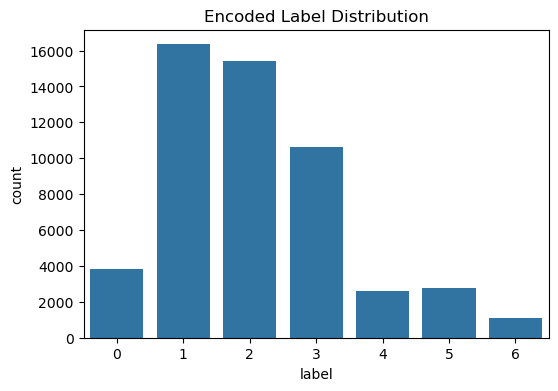

In [35]:
plt.figure(figsize=(6,4))
sns.countplot(data=final_df, x='label')
plt.title('Encoded Label Distribution')
plt.show()

**Train-Validation Split**

In [36]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val=train_test_split(
    final_df['text'],
    final_df['label'],
    test_size=0.2,
    random_state=42,
    stratify=final_df['label']
)

**Sanity Check Split**

In [37]:
y_train.value_counts(normalize=True)
y_val.value_counts(normalize=True)

label
1    0.310240
2    0.292398
3    0.202240
0    0.072886
5    0.052766
4    0.049065
6    0.020404
Name: proportion, dtype: float64

**Saving Processed Data**

In [38]:
train_df=pd.DataFrame({
    'text':X_train,
    'label':y_train
})

val_df=pd.DataFrame({
    'text':X_val,
    'label':y_val
})

train_df.to_csv("../data/processed/train_baseline.csv", index=False)
val_df.to_csv("../data/processed/val_baseline.csv", index=False)    
